<a href="https://colab.research.google.com/github/TheAnkitRai/Knowledge_Graph-1/blob/main/Knowledge_Graph_using_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Building a Knowledge Graph from Text Data**

## Importing libraries

In [ ]:
# importing Libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Getting the data

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
# Viewing top 5 sentences

candidate_sentences['sentence'].sample(5)

3152    rampal's last release of the year was apoorva lakhia's ek ajnabee opposite amitabh harivansh rai bachchan and perizaad zorabian.
312                                                                                animated cartoons came principally as short subjects.
3334                                                                                it was entered into the 1984 cannes film festival.\n
2946                                                                               she was in a much different head space and signing on
4283                                           the 42nd annual toronto international film festival was held from 7 to 17 september 2017.
Name: sentence, dtype: object

## Entity pairs extraction

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # checking if the token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # checking if the token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
# testing this function on a sentence:

get_entities("Ankit went to Delhi")

['Ankit', 'Delhi']

In [ ]:
# using this function to extract these entity pairs for all the sentences in our data:

entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:39<00:00, 108.98it/s]


Looking at some of these entities

In [ ]:

len(entity_pairs)

4318

In [ ]:
entity_pairs[30:40]

[['vivienne graham', 'former employee dr'],
 ['monster which', 'several monarch dr'],
 ['madison', 'mythological  texts'],
 ['joe morton', 'older  .'],
 ['godzilla', 'king themselves'],
 ['when  dougherty', 'when  reaction'],
 ['we', 'godzilla'],
 ['only  mandate', 'monarch'],
 ['ten  writers', 'treatment'],
 ['script', 'year']]

## Extracting Relation/Predicate

Predicate is actually the verb in our sentence

In [ ]:
# Rule based matching

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern]) # pattern has to be always given enclosed within a list

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
# Let's check this above function

get_relation("Ankit went to Delhi")

'went to'

In [ ]:
get_relation("Ankit is pursuing M Tech")

'pursuing'

In [ ]:
# let’s get the relations from all the Wikipedia sentences:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:40<00:00, 107.35it/s]


In [ ]:
# Looking at some of the most frequent predicates
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

## Building Knowledge Graph

In [ ]:
# creating a dataframe for entities and predicates

# subjects extracted from
source = [i[0] for i in entity_pairs]

# objects
target = [i[1] for i in entity_pairs]

# dataframe containing subjects, objects and predicates
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# use the networkx library to create a network from this dataframe

# Creating a directed graph

G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

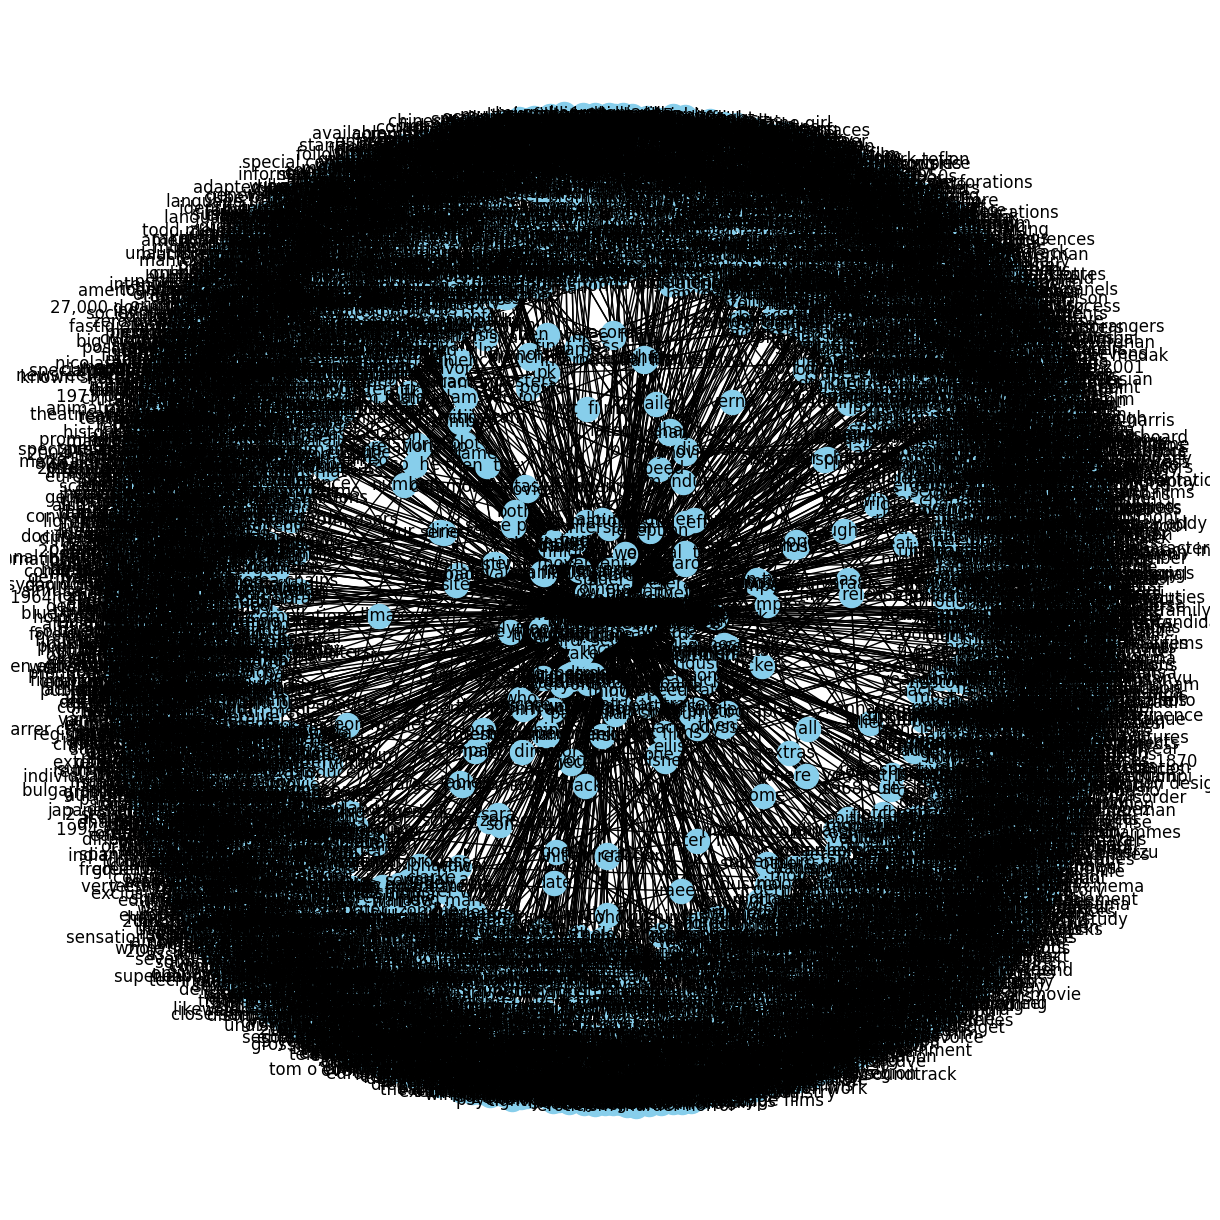

In [ ]:
# Plotting the network
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Visualizing smaller KGs

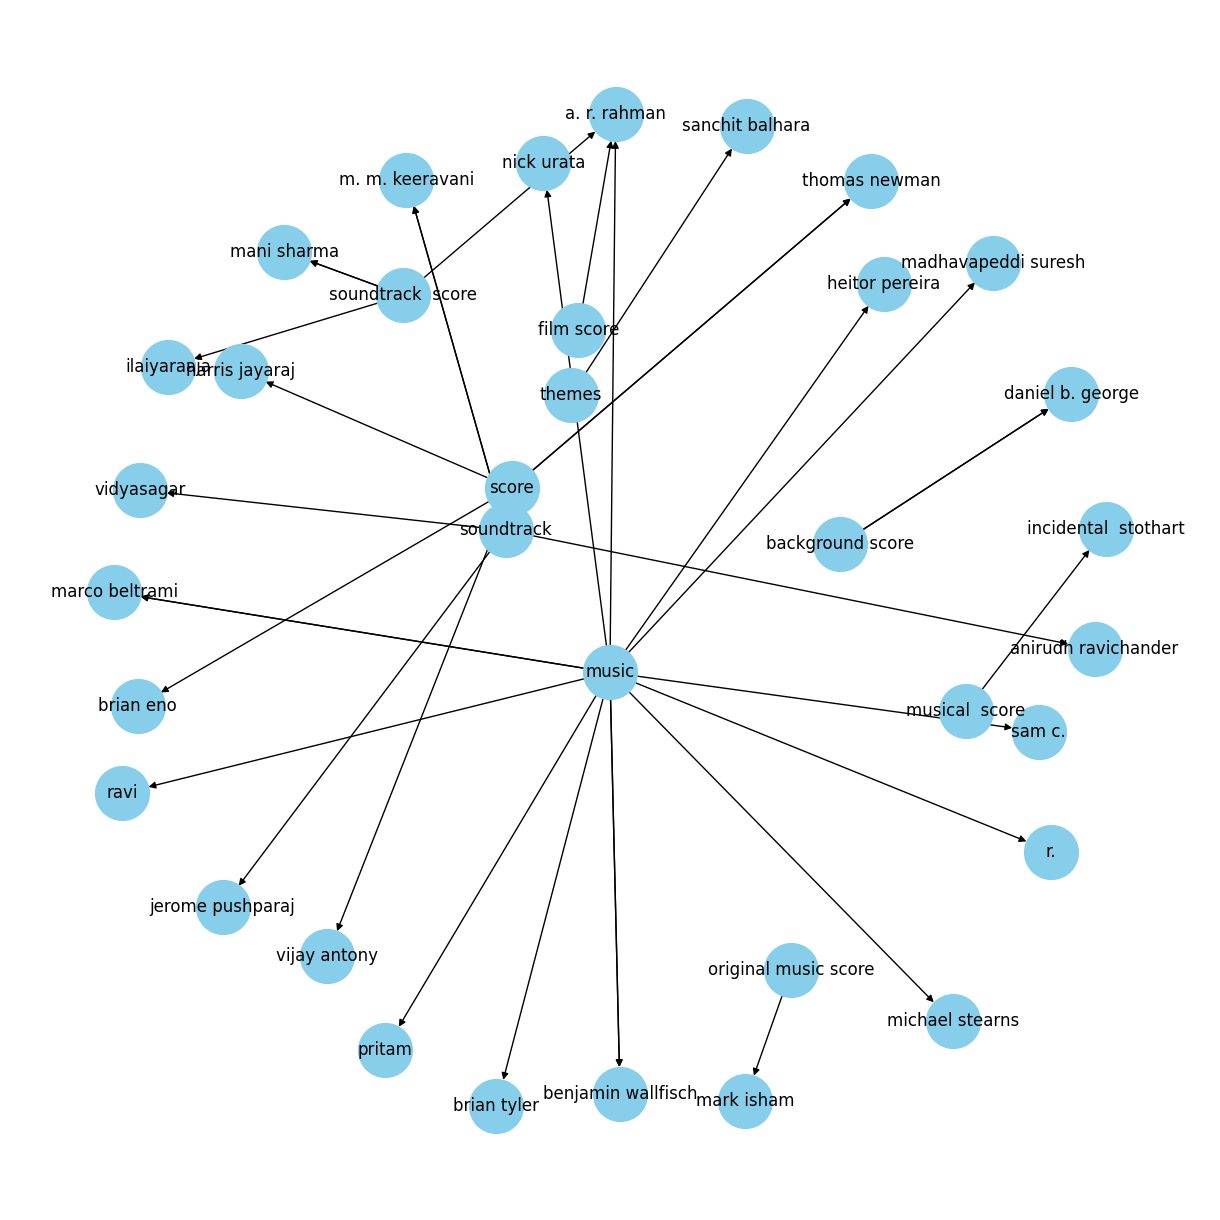

In [ ]:
# Plotting the knowledge graph for the realation 'composed by'
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

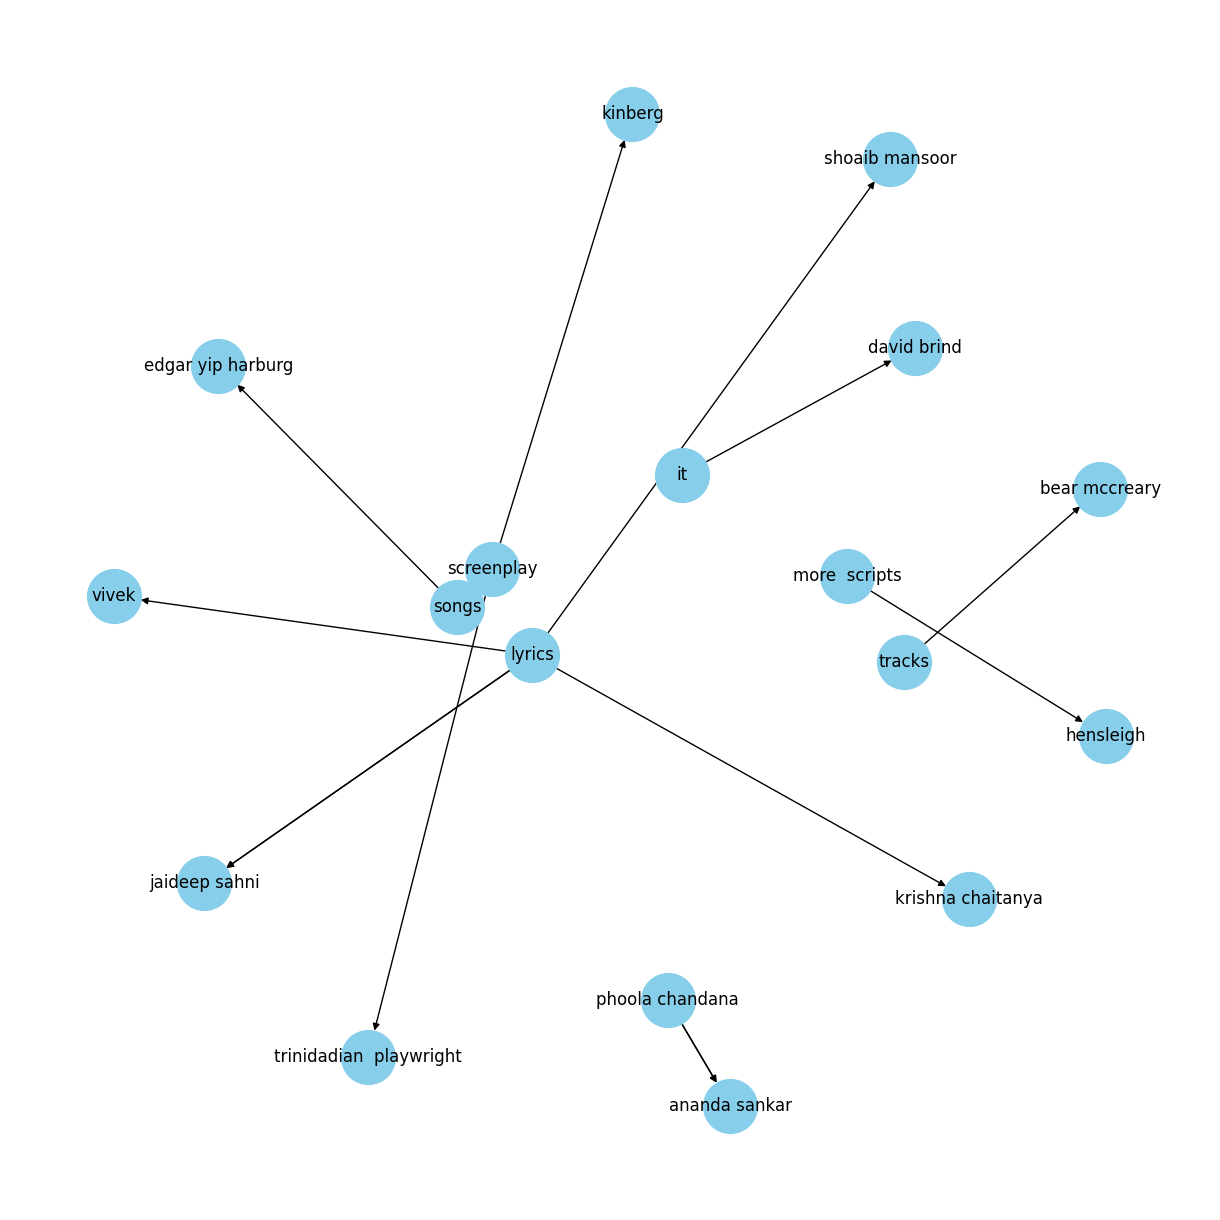

In [ ]:
# visualizing the graph for the “written by” relation

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()